In [1]:
import mitsuba as mi
import drjit as dr 
import matplotlib.pyplot as plt
mi.set_variant("cuda_ad_rgb")

# Surface Reconstruction based on Photometric Stereo

input:
- image $I\in\mathbb{R}^{256\times256\times3}$
- Light Source Information
  - LEDs position $P\in\mathbb{R}^{24\times3}$
  - LEDs intensity $E\in\mathbb{R}^{24\times3}$
  - LEDs direction $D\in\mathbb{R}^{24\times3}$
- Camera Information
  - Camera resolution
  - Camera Position
  - Camera fov
- Initial Estimation of Surface $Z_0\in\mathbb{R}^{256\times256}$

output:
- Estimation of Surface $Z\in\mathbb{R}^{256\times256}$

## Get Image $I$

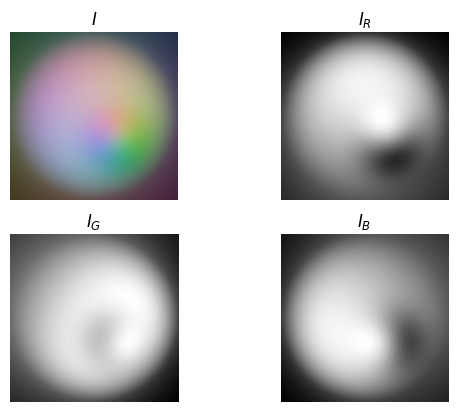

In [2]:
## get image I ##
bmp = mi.Bitmap('../scenes/img/normal-10-10.png')

I_t = mi.TensorXf(bmp)/256

I_R = I_t[:,:,0]
I_G = I_t[:,:,1]
I_B = I_t[:,:,2]

f, ax = plt.subplots(2,2)
ax[0,0].imshow(I_t); ax[0,0].axis('off');ax[0,0].set_title("$I$")
ax[0,1].imshow(I_R,cmap='gray');ax[0,1].axis('off');ax[0,1].set_title("$I_R$");
ax[1,0].imshow(I_G,cmap='gray');ax[1,0].axis('off');ax[1,0].set_title("$I_G$");
ax[1,1].imshow(I_B,cmap='gray');ax[1,1].axis('off');ax[1,1].set_title("$I_B$");

## Set LED Configuration

In [3]:
import utils.led_ring

N_LED = 24
LED0_pos = mi.Point3f(-34.41,0,-12.5)
LED_ring = utils.led_ring.LED_params(N_LED, LED0_pos)
P_LED = LED_ring.P
D_LED = LED_ring.D

## get LED intensity ##
A = 0.4
B = 0.5
LED_ring.set_sine_intensity(A,B)

## Set Camera Configuration

In [4]:
### Image pixel resolution ###
image_res = (256,256)
### camera origin          ###
cam_origin = mi.Point3f(0,0,-50)
### camera fov in mm       ###
cam_fov = (70,70)

from utils import camera 
cam = camera.Camera(cam_origin, image_res,cam_fov)

## Calculate Surface Normal and Surface Gradient

In [5]:
from utils import iristac

sensor = iristac.sensor(cam,LED_ring)
normal = sensor.get_surface_normal(I_t)

### Calculate gradient ###
import numpy as np
grad_x = np.reshape(-normal[0]/normal[2],(image_res[1],image_res[0]))
grad_y = np.reshape(-normal[1]/normal[2],(image_res[1],image_res[0]))

## Surface Reconstruction

In [7]:
### Ground truth ###
scene_ref = mi.load_file('../scenes/iristac_ply.xml')
si_ref = cam.shot(scene_ref)
Z_ref = si_ref.p[2]

In [8]:
from utils.depth_from_grad import frankotchellappa, fast_poisson
from decimal import Decimal

N_Pixel = image_res[0]*image_res[1]
"""Frankot-Chellappa depth-from-gradient algorithm."""
Z = frankotchellappa(grad_x,grad_y)
Z = Z*np.sqrt(cam_fov[0]*cam_fov[1]/N_Pixel)
error_rms = np.mean(np.sqrt((np.ravel(Z)-Z_ref)**2))
error_std = np.std((np.ravel(Z)-Z_ref)**2)
print("Frankot-Chellappa reconstruction error:\n\
rms error:  \t {0:.2E}\n\
std  error:  \t {1:.2E}\n\
".format(Decimal(error_rms),Decimal(error_std))
)


"""Fast Poisson Solver."""
Z = fast_poisson(grad_x,grad_y)
Z = Z*np.sqrt(cam_fov[0]*cam_fov[1]/N_Pixel)
error_rms = np.mean(np.sqrt((np.ravel(Z)-Z_ref)**2))
error_std = np.std((np.ravel(Z)-Z_ref)**2)
print("Fast Poisson Solver reconstruction error:\n\
rms error:  \t {0:.2E}\n\
std  error:  \t {1:.2E}\n\
".format(Decimal(error_rms),Decimal(error_std))
)

Frankot-Chellappa reconstruction error:
rms error:  	 1.38E-2
std  error:  	 8.66E-3

Fast Poisson Solver reconstruction error:
rms error:  	 1.51E-2
std  error:  	 9.79E-3



## Simulation of Tactile Image with Estimated Depth

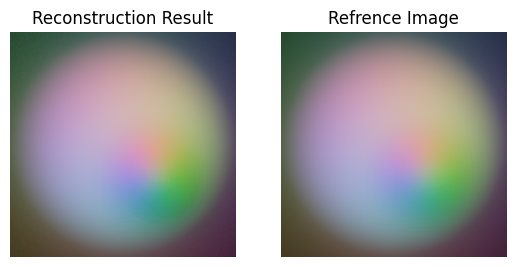

In [9]:
### Get Tactile Image with Estimation Depth ###
# sensor.set_Z0()
Z_t = mi.TensorXf(np.ravel(Z),(cam.image_res[0],cam.image_res[1]))
sensor.set_Z0(Z_t)
I_compute = sensor.get_tactile_img()

f, ax = plt.subplots(1,2)

ax[0].imshow(I_compute);ax[0].axis('off');  ax[0].set_title('Reconstruction Result')
ax[1].imshow(I_t);      ax[1].axis('off');  ax[1].set_title('Refrence Image')
plt.show()